In [1]:
import sys
import numpy as np
from tqdm import tqdm
import pandas as pd
import os


from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.metrics import ClassificationMetric
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy


# Ensure reproducibility
np.random.seed(1)

# Append a path if needed
sys.path.append("../")


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
original_dataset = AdultDataset()
df = pd.DataFrame(original_dataset.features, columns=original_dataset.feature_names)
df

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,...,native-country=Portugal,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia
0,25.0,7.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,38.0,9.0,1.0,1.0,0.0,0.0,50.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,28.0,12.0,1.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,44.0,10.0,0.0,1.0,7688.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,34.0,6.0,1.0,1.0,0.0,0.0,30.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,27.0,12.0,1.0,0.0,0.0,0.0,38.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45218,40.0,9.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45219,58.0,9.0,1.0,0.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45220,22.0,9.0,1.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
original_dataset.feature_names

['age',
 'education-num',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass=Federal-gov',
 'workclass=Local-gov',
 'workclass=Private',
 'workclass=Self-emp-inc',
 'workclass=Self-emp-not-inc',
 'workclass=State-gov',
 'workclass=Without-pay',
 'education=10th',
 'education=11th',
 'education=12th',
 'education=1st-4th',
 'education=5th-6th',
 'education=7th-8th',
 'education=9th',
 'education=Assoc-acdm',
 'education=Assoc-voc',
 'education=Bachelors',
 'education=Doctorate',
 'education=HS-grad',
 'education=Masters',
 'education=Preschool',
 'education=Prof-school',
 'education=Some-college',
 'marital-status=Divorced',
 'marital-status=Married-AF-spouse',
 'marital-status=Married-civ-spouse',
 'marital-status=Married-spouse-absent',
 'marital-status=Never-married',
 'marital-status=Separated',
 'marital-status=Widowed',
 'occupation=Adm-clerical',
 'occupation=Armed-Forces',
 'occupation=Craft-repair',
 'occupation=Exec-managerial',
 'occupation=Farm

#this code is only for the dataset adult, I should change this if I want to make it work for other datasets


Preprocessing  from https://github.com/Trusted-AI/AIF360/blob/main/aif360/algorithms/preprocessing/optim_preproc_helpers/data_preproc_functions.py

In [4]:
def load_preproc_data_adult(protected_attributes=None, sub_samp=False, balance=False):
    def custom_preprocessing(df):
        """The custom pre-processing function is adapted from
            https://github.com/fair-preprocessing/nips2017/blob/master/Adult/code/Generate_Adult_Data.ipynb
            If sub_samp != False, then return smaller version of dataset truncated to tiny_test data points.
        """

        # Group age by decade
        df['Age (decade)'] = df['age'].apply(lambda x: x//10*10) #rounds the age values to the nearest decade. so 23->20

        def group_edu(x): #this function replaces with <6 or >12 all the other years
            if x <= 5:
                return '<6'
            elif x >= 13:
                return '>12'
            else:
                return x

        def age_cut(x): #cuts the age a 70
            if x >= 70:
                return '>=70'
            else:
                return x

        def group_race(x): #white is the privileged group because we mark it with 1
            if x == "White":
                return 1.0
            else:
                return 0.0

        # Cluster education and age attributes.
        # Limit education range
        df['Education Years'] = df['education-num'].apply(lambda x: group_edu(x))
        df['Education Years'] = df['Education Years'].astype('category') #onverts Education Years to a categorical data type, which saves memory and can help in analysis by treating each unique value as a category.

        # Limit age range
        df['Age (decade)'] = df['Age (decade)'].apply(lambda x: age_cut(x))

        # Rename income variable
        df['Income Binary'] = df['income-per-year']
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K.', value='>50K', regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K.', value='<=50K', regex=True)

        # Recode sex and race
        df['sex'] = df['sex'].replace({'Female': 0.0, 'Male': 1.0})  #male=1, female=0
        df['race'] = df['race'].apply(lambda x: group_race(x))       #white=1, nonwhite=0
#creates a smaller version of the dataset
        if sub_samp and not balance:
            df = df.sample(sub_samp)
        if sub_samp and balance:
            df_0 = df[df['Income Binary'] == '<=50K']
            df_1 = df[df['Income Binary'] == '>50K']
            df_0 = df_0.sample(int(sub_samp/2))
            df_1 = df_1.sample(int(sub_samp/2))
            df = pd.concat([df_0, df_1])
        return df

    XD_features = ['Age (decade)', 'Education Years', 'sex', 'race'] #features of interest
    D_features = ['sex', 'race'] if protected_attributes is None else protected_attributes #protected attributes
    Y_features = ['Income Binary'] #target variable
    X_features = list(set(XD_features)-set(D_features)) #features without including protected attributes
    categorical_features = ['Age (decade)', 'Education Years'] #because we should treat them as categorical, not as numerical(continous)

    # privileged classes
    all_privileged_classes = {"sex": [1.0], #male
                              "race": [1.0]} #white

    # protected attribute maps
    all_protected_attribute_maps = {"sex": {1.0: 'Male', 0.0: 'Female'},
                                    "race": {1.0: 'White', 0.0: 'Non-white'}}

    return AdultDataset(
        label_name=Y_features[0], #income binary <50k, >50k
        favorable_classes=['>50K', '>50K.'], #classes that are favorable
        protected_attribute_names=D_features,
        privileged_classes=[all_privileged_classes[x] for x in D_features],
        instance_weights_name=None, #all samples are treated equally without weighting
        categorical_features=categorical_features,
        features_to_keep=X_features+Y_features+D_features, #nonProtectedAttributes+targetVariable+protectedAttributes (so pretty much XD_features + target variable )
        na_values=['?'], #any '?' values in the dataset will be treated as NaN or missing values.
        metadata={'label_maps': [{1.0: '>50K', 0.0: '<=50K'}], #maps the target variables to binary 1(>50k) and 0
                  'protected_attribute_maps': [all_protected_attribute_maps[x] #maps protected attributes to 1(sex=male, race=white) and 0
                                for x in D_features]},
        custom_preprocessing=custom_preprocessing) #custom function to make all the necessary transformations before loading it into AdultDataset format

In [5]:
privileged_group = [{'sex': 1}]
unprivileged_group = [{'sex': 0}]
preprocessed_dataset = load_preproc_data_adult(['sex'])


After preprocessing Adult dataset

label: This column represents the target variable or outcome of the dataset, indicating whether the individual's income is above or below a certain threshold (e.g., >50K or <=50K).


protected: This column is a binary indicator showing whether the individual belongs to a privileged or unprivileged group based on protected attributes, such as race or sex. (we used protected attribute = sex, so 1 would mean male and 0 would mean female)

In [6]:

# Convert to a Pandas DataFrame
df = pd.DataFrame(data=preprocessed_dataset.features, columns=preprocessed_dataset.feature_names)
df['label'] = preprocessed_dataset.labels  # Add the label column
df['protected'] = preprocessed_dataset.protected_attributes[:, 0]  # Add the protected attribute (e.g., 'sex' or 'race')

# Display the first few rows
df.head()


,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,Age (decade)=>=70,Education Years=6,Education Years=7,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,label,protected
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Check data types and null values
print(df.info())

# Summary statistics for numerical columns
print(df.describe())

# Count of each label (e.g., income level)
print(df['label'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   race                 48842 non-null  float64
 1   sex                  48842 non-null  float64
 2   Age (decade)=10      48842 non-null  float64
 3   Age (decade)=20      48842 non-null  float64
 4   Age (decade)=30      48842 non-null  float64
 5   Age (decade)=40      48842 non-null  float64
 6   Age (decade)=50      48842 non-null  float64
 7   Age (decade)=60      48842 non-null  float64
 8   Age (decade)=>=70    48842 non-null  float64
 9   Education Years=6    48842 non-null  float64
 10  Education Years=7    48842 non-null  float64
 11  Education Years=8    48842 non-null  float64
 12  Education Years=9    48842 non-null  float64
 13  Education Years=10   48842 non-null  float64
 14  Education Years=11   48842 non-null  float64
 15  Education Years=12   48842 non-null 

Comments:
- Race: 0 = non-white, 1 = white
- Sex:  0 = female,    1 = male
- Age (decade)= 10: person is in their 10s
- Age (decade)= 20: person is in their 20s
- Age (decade)= 30: person is in their 30s
..
- Education Years = 6: person has finishes 6 years of education
..




Mean:

For example:
race mean of 0.855 suggests about 85.5% of entries have a value of 1,  indicating that 85.5% of individuals are from a privileged race group (e.g., White).

Standard Deviation (std):

std indicates the spread or variability of the values in each column.
For binary columns, a higher standard deviation (closer to 0.5) suggests a more balanced distribution between 0 and 1. A lower standard deviation indicates one value (either 0 or 1) dominates.

The mean (0.855) indicates that 85.5% of the entries in race are 1 (privileged), meaning that 1 is indeed the dominant category.

In a binary variable:
A standard deviation close to 0.5 would suggest a more balanced distribution (closer to 50% for both categories).
A standard deviation lower than 0.5, like 0.35, implies less variability and suggests that the data points are clustered around one value more than the other.

In short:

Mean tells us which value is more common (in this case, 1).
Standard deviation tells us how tightly the data is clustered around the mean (0.855), confirming that there’s a dominant category with little spread.
    






Percentiles Interpretation:

25% (0.0): The 25th percentile is 0, meaning that at least 25% of the values in this column are 0 (Female).


50% (1.0): The 50th percentile (or median) is 1, which means that at least 50% of the values are 1 (Male). This suggests that Males are the majority in the dataset.


75% (1.0): The 75th percentile is also 1, indicating that at least 75% of the upper values are 1 (Male).

In [8]:
train_dataset, val_test_dataset = preprocessed_dataset.split([0.7], shuffle=True)
val_dataset, test_dataset = val_test_dataset.split([0.5], shuffle=True)

In [9]:
#check attributes of the dataset

dir(train_dataset)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_de_dummy_code_df',
 '_parse_feature_names',
 'align_datasets',
 'convert_to_dataframe',
 'copy',
 'export_dataset',
 'favorable_label',
 'feature_names',
 'features',
 'ignore_fields',
 'import_dataset',
 'instance_names',
 'instance_weights',
 'label_names',
 'labels',
 'metadata',
 'privileged_protected_attributes',
 'protected_attribute_names',
 'protected_attributes',
 'scores',
 'split',
 'subset',
 'temporarily_ignore',
 'unfavorable_label',
 'unprivileged_protected_attributes',
 'validate_dataset']

In [10]:
# Print general metadata and attributes about the dataset

print(" - Favorable Label:", preprocessed_dataset.favorable_label)
print(" - Unfavorable Label:", preprocessed_dataset.unfavorable_label)
print(" - Feature Names:", preprocessed_dataset.feature_names)
print(" - Protected Attribute Names:", preprocessed_dataset.protected_attribute_names)
print(" - Privileged Protected Attributes:", preprocessed_dataset.privileged_protected_attributes)
print(" - Unprivileged Protected Attributes:", preprocessed_dataset.unprivileged_protected_attributes)
print(" - Label Names:", preprocessed_dataset.label_names)
print(" - Training Dataset Shape:", preprocessed_dataset.features.shape)

 - Favorable Label: 1.0
 - Unfavorable Label: 0.0
 - Feature Names: ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
 - Protected Attribute Names: ['sex']
 - Privileged Protected Attributes: [array([1.])]
 - Unprivileged Protected Attributes: [array([0.])]
 - Label Names: ['Income Binary']
 - Training Dataset Shape: (48842, 18)


**Measuring Bias**

In [11]:
metric_train_dataset = BinaryLabelDatasetMetric(train_dataset,
                                             unprivileged_groups=unprivileged_group,
                                             privileged_groups=privileged_group)


In [12]:
print("The difference in mean outcomes (statistical parity difference) between unprivileged and privileged group = %f" % metric_train_dataset.mean_difference())

The difference in mean outcomes (statistical parity difference) between unprivileged and privileged group = -0.190244


metric_orig_train.mean_difference() calculates the difference in mean outcomes (also known as statistical parity difference) between the unprivileged and privileged groups.

This metric provides an indication of disparity in favorable outcomes (e.g., high income) between the two groups.

Using this formula, the negative value suggests that:

The probability of a favorable outcome (such as >50K income) is lower for the unprivileged group compared to the privileged group.
Specifically, the unprivileged group has a 19.02% lower chance of a favorable outcome compared to the privileged group.


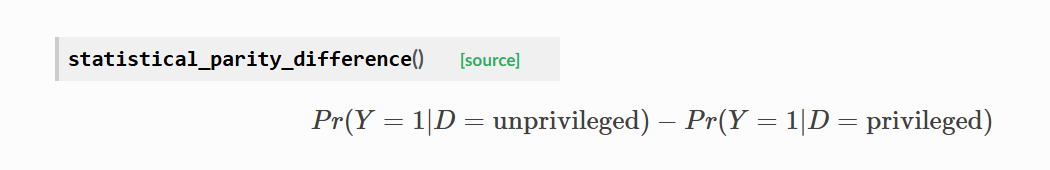

**Mitigating Bias**

In [13]:
reweighing = Reweighing(unprivileged_groups=unprivileged_group,
               privileged_groups=privileged_group)


In [14]:
reweighing.fit(train_dataset)
dataset_transf_train = reweighing.transform(train_dataset)

In [15]:
metric_transformed_train_dataset = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)

In [16]:
print("The difference in mean outcomes (statistical parity difference) between unprivileged and privileged group = %f" % metric_transformed_train_dataset.mean_difference())

The difference in mean outcomes (statistical parity difference) between unprivileged and privileged group = 0.000000


Model Training, Threshold Optimization and Evaluation

In [17]:
# Step 1: Standardize the features of the training dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_dataset.features)  # Scaled training features
y_train = train_dataset.labels.ravel()  # Flattened labels
sample_weights = train_dataset.instance_weights 

# Step 2: Instantiate and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=1)
log_reg.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Step 3: Predict on the training dataset
y_train_pred = log_reg.predict(X_train_scaled) # we are not using it

# Step 4: Scale validation dataset and predict probabilities for positive class
X_val_scaled = scaler.transform(val_dataset.features)
val_probs = log_reg.predict_proba(X_val_scaled)[:, 1]  # Scores for the positive class

# Step 5: Scale test dataset and predict probabilities for positive class
X_test_scaled = scaler.transform(test_dataset.features)
test_probs = log_reg.predict_proba(X_test_scaled)[:, 1]  # Scores for the positive class

# Step 6: Evaluate different thresholds for balanced accuracy on validation set
thresholds = np.arange(0.01, 1.0, 0.01)

balanced_accuracies = []

for threshold in thresholds:
    # Classify instances as favorable or unfavorable based on threshold
    y_val_pred = (val_probs >= threshold).astype(int)
    
    # Create a copy of val_dataset and assign the thresholded labels
    val_dataset_copy = copy.deepcopy(val_dataset)
    val_dataset_copy.labels = y_val_pred.reshape(-1, 1)  # Update labels with predictions

    # Use ClassificationMetric to calculate true positive rate and true negative rate
    val_metric = ClassificationMetric(val_dataset, val_dataset_copy,
                                      unprivileged_groups=unprivileged_group,
                                      privileged_groups=privileged_group)
    
    # Calculate balanced accuracy as the average of TPR and TNR
    true_positive_rate = val_metric.true_positive_rate()
    true_negative_rate = val_metric.true_negative_rate()
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
    balanced_accuracies.append(balanced_accuracy)

# Step 7: Find the index of the highest balanced accuracy and print results
best_index = np.argmax(balanced_accuracies)
best_threshold = thresholds[best_index]
best_balanced_accuracy = balanced_accuracies[best_index]

print(f"Best Balanced Accuracy: {best_balanced_accuracy}")
print(f"Optimal Classification Threshold: {best_threshold}")


Best Balanced Accuracy: 0.746316300422052
Optimal Classification Threshold: 0.29000000000000004


In [18]:
# Apply the optimal threshold found earlier to classify instances in the test set
y_test_pred = (test_probs >= best_threshold).astype(int)

# Create a copy of the test dataset and set the predicted labels
test_dataset_copy = copy.deepcopy(test_dataset)
test_dataset_copy.labels = y_test_pred.reshape(-1, 1)  # Update labels with predictions

# Calculate fairness and performance metrics
test_metric = ClassificationMetric(test_dataset, test_dataset_copy,
                                   unprivileged_groups=unprivileged_group,
                                   privileged_groups=privileged_group)

# Balanced Accuracy
true_positive_rate = test_metric.true_positive_rate()
true_negative_rate = test_metric.true_negative_rate()
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy: {balanced_accuracy}")

# Statistical Parity Difference
statistical_parity_difference = test_metric.statistical_parity_difference()
print(f"Statistical Parity Difference: {statistical_parity_difference}")

# Disparate Impact
disparate_impact = test_metric.disparate_impact()
print(f"Disparate Impact: {disparate_impact}")

# Average Odds Difference
average_odds_difference = test_metric.average_odds_difference()
print(f"Average Odds Difference: {average_odds_difference}")

# Equal Opportunity Difference
equal_opportunity_difference = test_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference: {equal_opportunity_difference}")

# Theil Index
theil_index = test_metric.theil_index()
print(f"Theil Index: {theil_index}")


Balanced Accuracy: 0.7437474047111203
Statistical Parity Difference: -0.35802197059905744
Disparate Impact: 0.279437051843998
Average Odds Difference: -0.3181275256379389
Equal Opportunity Difference: -0.37688211889530343
Theil Index: 0.1129175713864926


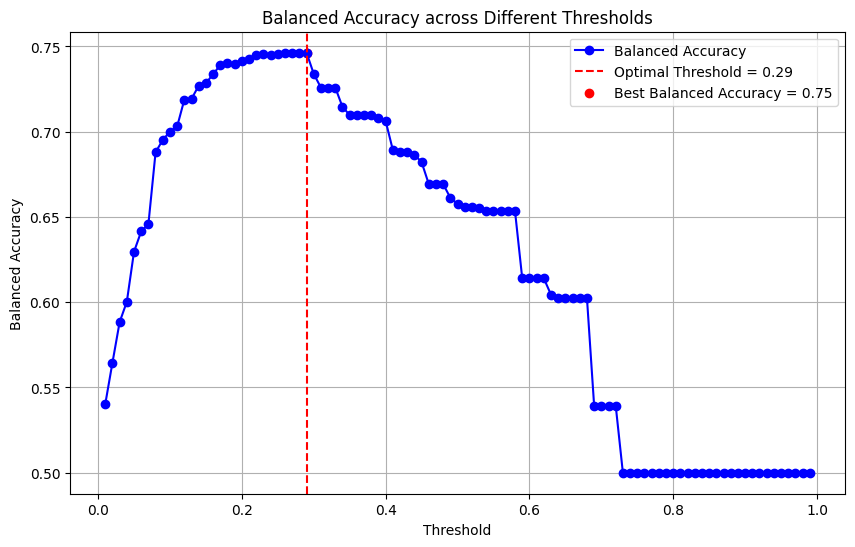

In [20]:

# Plotting the Balanced Accuracy across Different Thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy", marker='o', color='b')

# Marking the optimal threshold on the plot
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Optimal Threshold = {best_threshold:.2f}")
plt.scatter(best_threshold, best_balanced_accuracy, color='red', label=f"Best Balanced Accuracy = {best_balanced_accuracy:.2f}")

# Labeling the plot
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy across Different Thresholds")
plt.legend(loc="best")
plt.grid(True)
plt.show()


Training the model on reweighted (transformed) data 

In [24]:
# Step 1: Standardize the features of the reweighted training dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(dataset_transf_train.features)  # Scaled training features
y_train = dataset_transf_train.labels.ravel()  # Flattened labels
sample_weights = dataset_transf_train.instance_weights 

# Step 2: Instantiate and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=1)
log_reg.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Step 3: Scale the test dataset and predict probabilities for the positive class
X_test_scaled = scaler.transform(test_dataset.features)
test_probs = log_reg.predict_proba(X_test_scaled)[:, 1]  # Scores for the positive class

# Apply the previously determined optimal threshold to classify instances in the test set
y_test_pred = (test_probs >= best_threshold).astype(int)

# Create a copy of the test dataset and set the predicted labels
test_dataset_copy = copy.deepcopy(test_dataset)
test_dataset_copy.labels = y_test_pred.reshape(-1, 1)  # Update labels with predictions

# Calculate fairness and performance metrics on the test set
test_metric = ClassificationMetric(test_dataset, test_dataset_copy,
                                   unprivileged_groups=unprivileged_group,
                                   privileged_groups=privileged_group)

# Balanced Accuracy
true_positive_rate = test_metric.true_positive_rate()
true_negative_rate = test_metric.true_negative_rate()
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy: {balanced_accuracy}")

# Statistical Parity Difference
statistical_parity_difference = test_metric.statistical_parity_difference()
print(f"Statistical Parity Difference: {statistical_parity_difference}")

# Disparate Impact
disparate_impact = test_metric.disparate_impact()
print(f"Disparate Impact: {disparate_impact}")

# Average Odds Difference
average_odds_difference = test_metric.average_odds_difference()
print(f"Average Odds Difference: {average_odds_difference}")

# Equal Opportunity Difference
equal_opportunity_difference = test_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference: {equal_opportunity_difference}")

# Theil Index
theil_index = test_metric.theil_index()
print(f"Theil Index: {theil_index}")


Balanced Accuracy: 0.7235228881691287
Statistical Parity Difference: -0.0980829102778385
Disparate Impact: 0.8034763577205692
Average Odds Difference: -0.016977880329292455
Equal Opportunity Difference: -0.02225386175690436
Theil Index: 0.10507618526848914


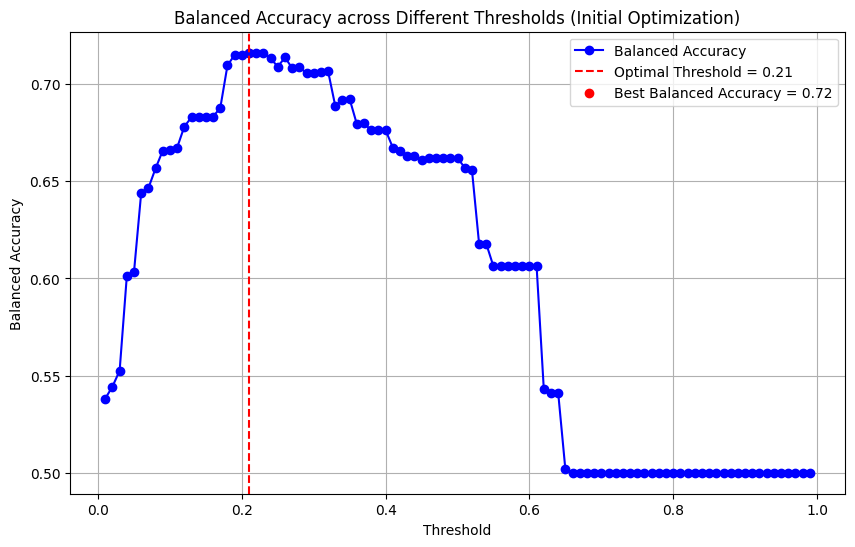

In [25]:
# Plotting the Balanced Accuracy across Different Thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy", marker='o', color='b')

# Marking the optimal threshold on the plot
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Optimal Threshold = {best_threshold:.2f}")
plt.scatter(best_threshold, best_balanced_accuracy, color='red', label=f"Best Balanced Accuracy = {best_balanced_accuracy:.2f}")

# Labeling the plot
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy across Different Thresholds (Initial Optimization)")
plt.legend(loc="best")
plt.grid(True)
plt.show()
